# Cox-Ross-Rubinstein Model

#### Work done by : Abdelhafid Souilmi 

We import numpy and matplotlib.plot. We also import later on scipy.stats.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1st Part 

### Prices generation :
The function $S_n$ returns all possible values of the price at the date $j$, using the given parameters.
In the Cox-Ross-Rubenstein model, returns at any moments can only have two distinct values: $\{u,d\}$ s.t. : $u= exp(bh_n+\sigma \sqrt h_n)$ and $b= exp(bh_n-\sigma \sqrt h_n)$.

Given a price $S_j$ at time $j$ , we only have two possible outcomes at $j+1$, which are $uS_j$ and $dS_j$.

The function $Sn(T,n,b,\sigma,j)$ returns all possible prices at date j.

In [2]:
#Qst 1.a)
S0=100
def Sn(T,n,b,sigma,j):
    h=T/n
    u=np.exp(b*h+sigma*np.sqrt(h))
    d=np.exp(b*h-sigma*np.sqrt(h))
    v=(j-np.arange(0,j+1))*np.log(u)+np.arange(0,j+1)*np.log(d)
    s= S0*np.exp(v)
    return s

We test this function and we find indeed a tree for all the possible values.
We use the parameters provided in Question e).

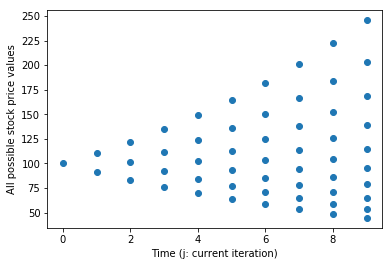

In [3]:
results=[Sn(2,20,0.05,0.3,i) for i in range(10)]
x,y=[],[]
for i in range(len(results)): 
    for j in range(results[i].shape[0]):
        y.append(results[i][j])
        x.append(i)
plt.ylabel("All possible stock price values")
plt.xlabel("Time (j: current iteration)")
plt.scatter(x,y)

### All Possible payoff outcomes :

We know that the payoff of a european call option at maturity is $(S_T-K)^+ $.

We use this formula to get all the possible payoff outcomes.

In [4]:
#Qst 1.b)
def payoffn(T,n,b,sigma,K):
    prices=Sn(T,n,b,sigma,T)
    prices=prices-K
    prices= prices*(prices>0)
    return prices

In [5]:
results=payoffn(2,50,0.05,0.3,90)
print(results) 

[23.2015871  10.40080107 -0.        ]


### Initial call price

To calculate the price of the call we use the formula : 
$$ p^n(B^n) = S_0 B(n,\frac{q_n u_n}{R_n},\eta_n)- Ke^{-rT}B(n,q_n,\eta_n)$$

With, $u_n = e^{bh_n+\sigma\sqrt{h_n}}, ~ d_n = e^{bh_n-\sigma\sqrt{h_n}}$

$R_n= e^{rT/n}, ~ q_n=\frac{R_n-d_n}{u_n-d_n}$
and $~~ \eta_n=inf\{j: S_0u_n^jd_n^{n-j} \geq K\}$

We can calculate $\eta_n$ using the following, $S_0~u_n^j~d_n^{n-j} \geq K \iff j\geq \frac{log(K)-log({S_0d^n})}{log({u})-log({d})}$ since $u>d$, hence $log(u)-log({d})>0$
which finally gives us, $$\eta_n= floor(\frac{log(K)-log(S_0)-nlog(d)}{log(u)-log(d)})+1$$

We also use $$B(n,p,\eta)=1-Prob\{ Bin(n,p)\leq \eta -1\},~ for~~\eta \in N$$

In [6]:
#Qst 1.c)
import scipy.stats as st

def B(n,p,eta):
    return 1-st.binom.cdf(eta-1,n,p)

def calln(Si,T,n,r,b,sigma,K):
    h=T/n
    u=np.exp(b*h+sigma*np.sqrt(h))
    d=np.exp(b*h-sigma*np.sqrt(h))
    
    R=np.exp(r*T/n)
    q=(R-d)/(u-d)
    #we use the formula above for eta
    eta= np.floor( (np.log(K)-np.log(Si)-n*np.log(d))/(np.log(u)-np.log(d))) +1
    result= Si*B(n,q*u/R,eta)-K*np.exp(-r*T)*B(n,q,eta)
    return result

#### Remark:
We have a value of 0.3 for $\sigma$ which corresponds to the standard average of a year volatility, hence we should give the time T in years, so no converting is needed.

We test the calln function to see if the outcome is reasonable and would behave as expected.

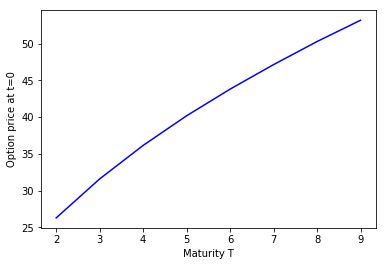

In [7]:
#Testing the function for multiple values of K
T=range(2,10)
callsPrices=[ calln(S0,t,50,0.05,0.05,0.3,90) for t in T]

plt.ylabel("Option price at t=0")
plt.xlabel("Maturity T")
plt.plot(T,callsPrices,c='b')

### Hedging 

We have the formula for hedging for a given price $S_{n-1}^n$ at step n-1:  

$$\theta_{n-1}^n(S_{n-1}^n)= \frac{(u_nS_{n-1}^n-K)^+-(d_nS_{n-1}^n-K)^+}{u_nS_{n-1}^n-d_nS_{n-1}^n}$$

Using the formula provided in the lecture notes, we have for $k<n$:

$$\theta_{k}^n(S_{k}^n)= \frac{B_{k+1}^n(u_nS_{k}^n)-B_{k+1}^n(d_nS_{k}^n)}{u_nS_{k}^n-d_nS_{k}^n}$$

We can calculate $B_k^n$, using:
 
$$\begin{equation} \label{eq1}
\begin{split}
B_k^n &= \mathbb{E}_k^{\mathbb{Q}_n}( \tilde{B}_{k+1}^n)\\
 & = \frac{1}{R} \mathbb{E}_k^{\mathbb{Q}_n}( {B}_{k+1}^n)\\
 & = \frac{1}{R^{n-k}} \mathbb{E}_k^{\mathbb{Q}_n}( {B}_{n}^n)\\
 & = \frac{1}{R^{n-k}} \mathbb{E}_k^{\mathbb{Q}_n}( ({S}_{n}^n-K)^+)\\
 & = calln(S_{k}^n,T-\frac{kT}{n},n-k,r,b,\sigma,K)
\end{split}
\end{equation}$$

The last equality is derived from the expression of the initial value of a call. So $B_k^n$ is the initial price of a call option with $S_0= S_k$ and $T'= T-t_k$


We can also calculate $B_k^n$ using this formula:
$$ B_k^n(\omega_k)=\frac{1}{R^{n-k}} \sum_{i=0}^{n} q_n^i(1-q_n)^{n-i}[u_n^i d_n^{n-i}{S}_{k}^n(\omega_k)-K]^+ $$

But we would rather use the following equation : $$B_k^n(\omega_k)=calln(S_{k}^n(\omega_k),T-\frac{kT}{n},n-k,r,b,\sigma,K)$$

In [10]:
#Qst 1.d)
#no particular order was asked so I kept the same order of the vector s
def deltan(T,n,r,b,sigma,K,j):
    h=T/n
    u=np.exp(b*h+sigma*np.sqrt(h))
    d=np.exp(b*h-sigma*np.sqrt(h))
    S= Sn(T,n,b,sigma,j)
    delta= calln(u*S,T-(j+1)*T/n,n-j-1,r,b,sigma,K)-calln(d*S,T-(j+1)*T/n,n-j-1,r,b,sigma,K)
    delta/= u*S-d*S
    return delta
    

### Dependence effect of Calln and Deltan on the strike K

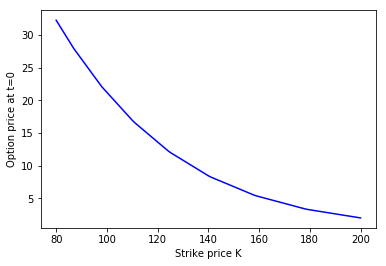

In [8]:
#Qst 1.e)
K=np.arange(80,201)

callsPrices=[ calln(S0,2,50,0.05,0.05,0.3,k) for k in K]

plt.ylabel("Option price at t=0")
plt.xlabel("Strike price K")
plt.plot(K,callsPrices,c='b')

$\blacktriangleright \textbf{Remark}:$ 
We can clearly see that the option price decreases when K increases which is what we would normally expect.
We can also see that as K gets bigger the call prices goes to 0.

In [11]:
cJ=[10,20,25,30,40] #chosen moments j
deltaValues=[np.zeros([cj+1,len(K)]) for cj in cJ]

for k in range(len(cJ)):
    for i in range(len(K)):
        deltaValues[k][:,i]=deltan(2,50,0.05,0.05,0.3,K[i],cJ[k])

<Figure size 432x288 with 0 Axes>

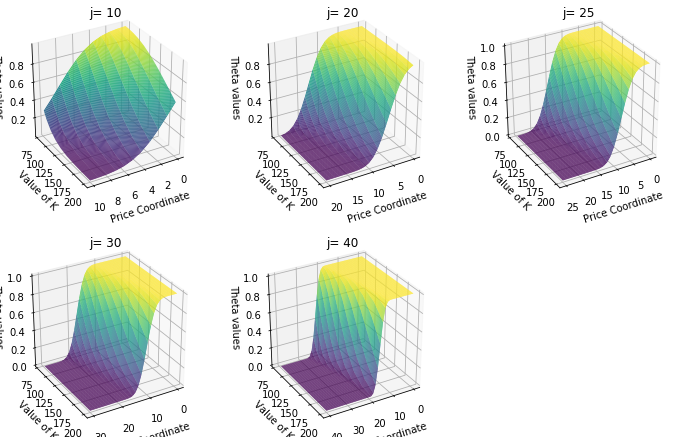

In [13]:
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()

fig = plt.figure(figsize=(12,12))

for i in range(1,len(cJ)+1):
    x= np.arange(cJ[i-1]+1)
    X,Y=np.meshgrid(x,K)
    ax = fig.add_subplot(330+i, projection='3d')
    ax.plot_surface(X, Y, deltaValues[i-1].T, rstride=1, cstride=1,cmap='viridis', edgecolor='none')
    ax.view_init(30,60)
    ax.set_xlabel('Price Coordinate')
    ax.set_ylabel('Value of K')
    ax.set_zlabel('Theta values')
    ax.set_title('j= {}'.format(cJ[i-1]))

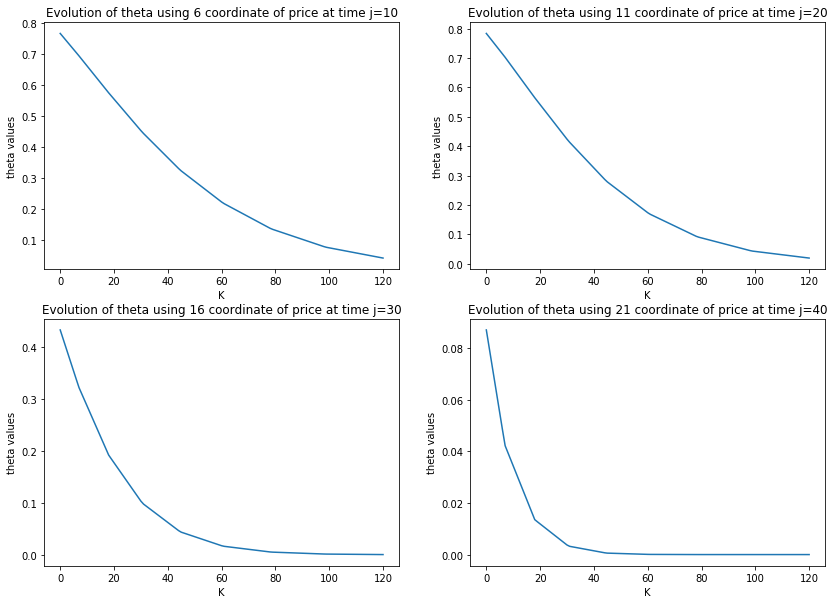

In [17]:
#Projection 2D
i=1
plt.figure(figsize=(14,10))
cj=[10,20,30,40]
for j in cj:
    plt.subplot(2,2,i)
    plt.plot(deltaValues[i-1][j//2+1,:])
    plt.title("Evolution of theta using {} coordinate of price at time j={}".format(j//2+1,j))
    plt.xlabel("K")
    plt.ylabel("theta values")
    i+=1
plt.show()

$\blacktriangleright \textbf{Remark}:$

Looking at the 3D surface graph we can see that for every price coordinate and for all the shown instants j, we see that $\theta_j^n$ decreases when $K$ increases.

This is what we expect since, having a bigger strike value $K$, we would be less inclined to invest in the option and rather more inclined to invest in the non-risky asset.

<b>!!!</b> We also see that as time goes by ($j$ increases)<b> the slope of the curve increases</b>.

## 2nd Part

### Black Scholes call price:

We use the classical formula for the Black Scholes european call price. This formula can easily be found as a limit of the initial Cox-Ross-Rubenstein model which is what we will try to prove in the following section. 

$$ call(T,K)= S_0 \textbf{N}(d_+(S_0,\tilde{K},\sigma^2T))-\tilde{K} \textbf{N}(d_-(S_0,\tilde{K},\sigma^2T))$$

Where $\textbf{N}$ is the cumulative distribution function of a standard normal variable.

In [18]:
#Qst 2.a)
S0=100
def d1(s,k,v):
    return np.log(s/k)/np.sqrt(v)+np.sqrt(v)/2
def d2(s,k,v):
    return np.log(s/k)/np.sqrt(v)-np.sqrt(v)/2
def call(T,r,sigma,K):
    return S0*st.norm.cdf(d1(S0,K*np.exp(-r*T),sigma*sigma*T))-K*np.exp(-r*T)*st.norm.cdf(d2(S0,K*np.exp(-r*T),sigma*sigma*T))

### Evaluating the relative error:

In [19]:
#Qst 2.b)
def err(T,n,r,b,sigma,K):
    return calln(S0,T,n,r,b,sigma,K)/call(T,r,sigma,K)-1

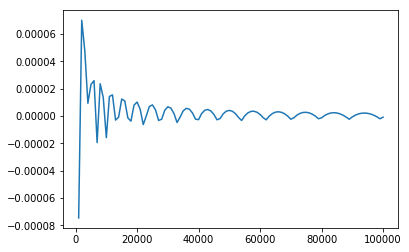

In [20]:
N=1000*np.arange(1,101)
er=err(2,N,0.05,0.05,0.3,105)

plt.plot(N,er)

As shown theoretically, $calln \rightarrow call$.
One interesting thing we observe, is that we have:$\textbf{ some regular spikes that reappearing with an increasing period.}$